In [1]:
import pickle as pkl
import numpy as np
from numpy import *
import xarray as xr
#import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#masking
import os
import pdb
os.chdir("/home/madhumadi/sd/")
#model_files =  "nc_files/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.PRECT.19200101-20051231.nc"
observed = 'nc_files/obs_1920_to_2005_no_leap.nc'
obs=xr.open_dataset(observed)
#model=xr.open_dataset(model_files)
import matplotlib.pyplot as plt
from datetime import datetime
import sys

In [2]:
obs

<xarray.Dataset>
Dimensions:             (lat: 129, lon: 135, time: 31390)
Coordinates:
  * lat                 (lat) float64 6.5 6.75 7.0 7.25 ... 38.0 38.25 38.5
  * lon                 (lon) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * time                (time) datetime64[ns] 1920-01-01 ... 2005-12-31
Data variables:
    precipitation (mm)  (time, lat, lon) float32 ...

In [3]:
mask = xr.where(obs["precipitation (mm)"][0]>=0,1,np.nan)
total_lat_start = obs.lat.values[0]
total_lat_end = obs.lat.values[-1]
total_long_start = obs.lon.values[0]
total_long_end = obs.lon.values[-1]


In [4]:
obs_1920_2005 = obs["precipitation (mm)"].sel( time = slice('1920-01-01','2005-12-31'))
obs_1920_2005

<xarray.DataArray 'precipitation (mm)' (time: 31390, lat: 129, lon: 135)>
[546656850 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2005-12-31

In [5]:
interpolated=xr.open_dataset('/home/madhumadi/sd/nc_files/MPI_1920_to_2005.nc')

In [6]:
interpolated_g=interpolated.rename({'__xarray_dataarray_variable__':'gcm'})

In [7]:
interpolated1=interpolated_g['gcm']

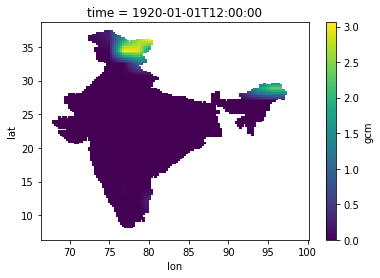

In [8]:
interpolated1[0].plot()

In [9]:
interpolated1

<xarray.DataArray 'gcm' (time: 31412, lat: 129, lon: 135)>
[547039980 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0

In [10]:
pwd

'/home/madhumadi/sd'

In [11]:
# calculation for quantile mappings
def lat_lon_india(data):
    total_lat = data.lat.values
    total_long = data.lon.values

    good_lat = []

    good_lon = []

    for i, lat in enumerate(total_lat):

        for j, lon in enumerate(total_long):

            sanity_check = data.sel(lat=lat, lon=lon, method="nearest")

            sanity_check = sanity_check['precipitation (mm)'][0]

            if np.isnan(sanity_check):

                continue

            else:

                good_lat.append(lat)

                good_lon.append(lon)

    return (good_lat, good_lon)
lat_obs_india, lon_obs_india =  lat_lon_india(obs)

In [12]:
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
qmap = importr('qmap')
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [13]:
obs

<xarray.Dataset>
Dimensions:             (lat: 129, lon: 135, time: 31390)
Coordinates:
  * lat                 (lat) float64 6.5 6.75 7.0 7.25 ... 38.0 38.25 38.5
  * lon                 (lon) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * time                (time) datetime64[ns] 1920-01-01 ... 2005-12-31
Data variables:
    precipitation (mm)  (time, lat, lon) float32 ...

In [21]:
def quantile_mapping_params(observation, model):

    q_map = qmap.fitQmap(observation, model, method="RQUANT", qstep=0.01, wet_day=True)

    qm1 = qmap.doQmap(model, q_map)

    qm1 = pandas2ri.ri2py(qm1)

    dict = {}

    dict['values'] = qm1

    dict['parameters'] = q_map

    return dict
def model_quantile_mapping(model, observed,lat_obs_india,lon_obs_india):
    total_lat = observed.lat.values
    total_long = observed.lon.values
    shapes = observed['precipitation (mm)'].shape
    quant_mapped_models = []

    for i, lat in enumerate(total_lat):
        print(i)
        for j, lon in enumerate(total_long):
            try:

                observed1 = observed.sel(lat=observed.lat[i], lon=observed.lon[j], method="nearest")
                #print(observed1[0])
                sanity_check = observed1['precipitation (mm)'][0]
                #sanity_check = observed1[0]

                if np.isnan(sanity_check):

                    continue

                else:

                    observation = observed.sel(lat=observed.lat[i], lon=observed.lon[j], method="nearest")['precipitation (mm)']
                    #observation = observed.sel(lat=observed.lat[i], lon=observed.lon[j], method="nearest")

                    model_output = model.sel(lat=observed.lat[i], lon=observed.lon[j], method="nearest")

                    #model_output = np.nan_to_num(model_output)
                    model_output = np.nan_to_num(model_output)
                    observation = np.nan_to_num(observation)

                    temp = quantile_mapping_params(observation, model_output)
                    #print(lat)

                    quant_mapped_models.append(temp)
            except:
                print('#############')


    return(quant_mapped_models)


In [22]:
interpolated1

<xarray.DataArray 'gcm' (time: 31412, lat: 129, lon: 135)>
[547039980 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0

In [23]:
quant_mapped_models_observed = model_quantile_mapping(interpolated1, obs,lat_obs_india,lon_obs_india)

0
1
2
3
4
5
6
7
#############
#############
#############
#############
8
#############
#############
#############
#############
#############
#############
9
#############
#############
#############
#############
#############
#############
#############
10
#############
#############
#############
#############
#############
#############
#############
11
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
12
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
13
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
14
#############
#############
#############
#############
#############
#############
#############
#############
#############

#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
39
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
40
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############


#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
54
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
55
#############
#############


#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
63
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
64
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
65
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
70
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
72
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
79
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

#############
#############
#############
#############
#############
#############
#############
#############
85
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
###

R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############


R[write to console]: Error in a[2, 2] : subscript out of bounds
Calls: <Anonymous> -> ffun -> fitQmapRQUANT.default



#############
90
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############
#############


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
interpolated1

<xarray.DataArray 'gcm' (time: 31412, lat: 129, lon: 135)>
[547039980 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0

In [20]:
quant_mapped_models_observed 

[]

In [17]:
def save_as_pickled_object(obj, filepath):

    """

    This is a defensive way to write pickle.write, allowing for very large files on all platforms

    """

    max_bytes = 2**31 - 1

    bytes_out = pkl.dumps(obj)

    n_bytes = sys.getsizeof(bytes_out)

    with open(filepath, 'wb') as f_out:

        for idx in range(0, n_bytes, max_bytes):

            f_out.write(bytes_out[idx:idx + max_bytes])


In [ ]:
save_as_pickled_object(quant_mapped_models_observed,'/home/akash/sd/akma_d_bcsd_miroc.pkl' )

In [ ]:
def bcsd(observed_nc):
    with open('/home/akash/sd/akma_d_bcsd_miroc.pkl', 'rb') as f:
        loaded_pickle_object = (pkl.load(f))
    processed_xarray_datasets = []
    processed_parameters_datasets = []
    corr_gcms_only_values = []
    for corr_gcm_with_params in loaded_pickle_object:
        corr_gcms_only_values.append(corr_gcm_with_params['values'])

    corr_gcms_only_values = np.asarray(corr_gcms_only_values)
    lat_file = os.getcwd() + '/' + 'good_geos' + '.pkl'

    if os.path.exists(lat_file):
        with open(lat_file, 'rb') as f:
            geos = (pkl.load(f))
    else:
        good_lat_lon = (good_geos(observed_nc))
        with open(lat_file, 'wb') as f:
            pkl.dump(good_lat_lon, f, -1)
        with open(lat_file, 'rb') as f:
            geos = (pkl.load(f))
    lats = geos[0]
    lons = geos[1]
    zipped_lat_lon = list(zip(lats, lons))
    lats_unique = (np.unique(lats))
    lons_unique = (np.unique(lons))
    lats_mesh, lons_mesh = np.meshgrid(lats_unique, lons_unique)
    mesh_shape = (lats_mesh.shape)
    shape_mesh = (lats_mesh.shape)
    zipped_gridded_list = list(zip(lats_mesh.flatten(), lons_mesh.flatten()))
    shape_gcm_values = (corr_gcms_only_values[0][:].shape)
    gcm_corrected_values = np.empty((len(zipped_gridded_list), shape_gcm_values[0]))
    gcm_corrected_values[:] = np.nan

    #print(corr_gcms_only_values)
    #print(corr_gcms_only_values.shape)

    for i, val in enumerate(zipped_lat_lon):
        #print(zipped_gridded_list.index(val))
        #print(gcm_corrected_values[zipped_gridded_list.index(val), :].shape)
        #print('i: ',i,'val: ',val)
        print(i)
        try:
            gcm_corrected_values[zipped_gridded_list.index(val), :] = corr_gcms_only_values[i][:]
        except:
            pass
        #if isnan(corr_gcms_only_values[1][i]):
         #   continue
        #else:
            #print(corr_gcms_only_values[:][i].shape)
         #   gcm_corrected_values[zipped_gridded_list.index(val), :] = corr_gcms_only_values[i][:]
    
    gcm_corrected_values = gcm_corrected_values.flatten()

    gcm_corrected_values = gcm_corrected_values.reshape((mesh_shape[0], mesh_shape[1], shape_gcm_values[0])).transpose()
    xr_object = xr.Dataset({"observation": (('time', 'lat', 'lon'), gcm_corrected_values)},coords={"lat": lats_unique, "lon": lons_unique, "time": xr.cftime_range('1920-01-01','2005-12-31', calendar='noleap')})
        
    return xr_object
gcm_mice_corrected_obs_divya = bcsd(obs)

In [ ]:
obs_o=xr.open_dataset('observations_117_118.nc')

In [ ]:
gcm_mice_corrected_obs_divya

In [ ]:
diff=obs_o['precipitation (mm)'].mean(dim='time')-gcm_mice_corrected_obs_divya['observation'].mean(dim='time')

In [ ]:
diff.plot(robust=True)

In [19]:
gcm_mice_corrected_obs_divya['observation']

<xarray.DataArray 'observation' (time: 31390, lat: 117, lon: 118)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-31 00:00:00
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25

In [40]:
gcm_mice_corrected_obs_divya.to_netcdf('/home/akash/sd/divya/ak_ma_divya_bcsd_cesm.nc')

In [43]:
def quantiles(test1, test2):

    test1.sort()

    quantile_levels1 = np.arange(len(test1), dtype=float) / len(test1)



    test2.sort()

    quantile_levels2 = np.arange(len(test2), dtype=float) / len(test2)



    # Use the smaller set of quantile levels to create the plot

    quantile_levels = quantile_levels2



    # We already have the set of quantiles for the smaller data set

    quantiles2 = test2



    # We find the set of quantiles for the larger data set using linear interpolation

    quantiles1 = np.interp(quantile_levels, quantile_levels1, test1)



    # Plot the quantiles to create the qq plot

    pylab.plot(quantiles1, quantiles2)



    # Add a reference line

    maxval = max(test1[-1], test2[-1])

    minval = min(test1[0], test2[0])

    pylab.plot([minval, maxval], [minval, maxval], 'k--')

    pylab.show()




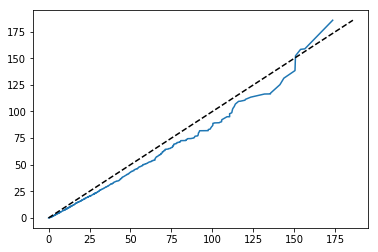

In [46]:
import pylab
quantiles(np.asarray(obs_o['precipitation (mm)'].sel(lat=30,lon=77.0)), np.asarray(gcm_mice_corrected_obs_divya['observation'].sel(lat=30.,lon=77.0)))

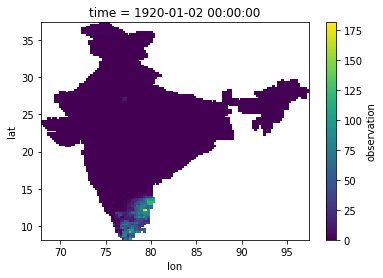

In [41]:
gcm_mice_corrected_obs_divya['observation'][1].plot()

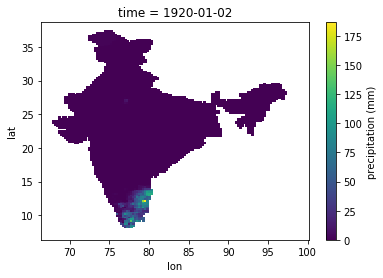

In [42]:
obs_1920_2005[1].plot()

In [16]:
from rpy2.robjects.packages import importr
utils = importr("utils")
extremes = importr("extRemes")
ismev = importr("ismev")
eva = importr("eva")
gnFit = importr("gnFit")
from netCDF4 import Dataset
import time
from datetime import datetime
from matplotlib.offsetbox import AnchoredText
from netCDF4 import num2date, date2num
statis = importr('stats')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [17]:
def RL_calcuation(block_maxima):
    try:
        gev_fit =  eva.gevrFit(block_maxima)
    
        MLE_est = list(gev_fit.rx2('par.ests'))

        params = {}
        RL_100_1 = []
        RL_30_1 = []
        LB_RL_100= []
        UB_RL_100= []
        LB_RL_30= []
        UB_RL_30= []
        params['location'] = MLE_est[0]

        params['scale'] =  MLE_est[1]

        params['shape'] = MLE_est[2]

        if MLE_est[1]<0:
            MLE_est[1] = 0.01

        y = eva.rgevr(10000, 1, loc = MLE_est[0], scale = MLE_est[1], shape = MLE_est[2])

        sig_test = statis.ks_test(block_maxima, y)

        params['p_val'] = sig_test.rx2('p.value')[0]
    

    #print(params)
        if params['p_val']>0.05:
            try:
                temp1 = eva.gevrRl(gev_fit, 100, method = "delta")
                RL_100_1 = temp1.rx2('Estimate')[0]
                LB_RL_100 = temp1.rx2('CI')[0]
                UB_RL_100 = temp1.rx2('CI')[1]
                temp2 = eva.gevrRl(gev_fit, 30, method = "delta")
                RL_30_1 = temp2.rx2('Estimate')[0]
                LB_RL_30 = temp2.rx2('CI')[0]
                UB_RL_30 = temp2.rx2('CI')[1]
                if UB>RL and RL >0:
                    LB_RL_100 = LB_RL_100
                    UB_RL_100 = UB_RL_100
                    LB_RL_30 = LB_RL_30
                    UB_RL_30 = UB_RL_30
                else:
                    LB_RL_100 = np.nan
                    UB_RL_100 = np.nan
                    LB_RL_30 = np.nan
                    UB_RL_30 = np.nan
            except:
                pass
        else:
            params['p_val'] = np.nan
            params['location'] = np.nan
            params['scale'] = np.nan
            params['shape'] = np.nan
            RL_100_1 = np.nan
            RL_30_1 = np.nan
            LB_RL_100 = np.nan
            UB_RL_100 = np.nan
            LB_RL_30 = np.nan
            UB_RL_30 = np.nan
    except:
        params = {}
        params['p_val'] = np.nan
        params['location'] = np.nan
        params['scale'] = np.nan
        params['shape'] = np.nan
        RL_100_1 = np.nan
        RL_30_1 = np.nan
        LB_RL_100 = np.nan
        UB_RL_100 = np.nan
        LB_RL_30 = np.nan
        UB_RL_30 = np.nan
    return [RL_100_1, RL_30_1,LB_RL_100,UB_RL_100,LB_RL_30,UB_RL_30,params]


In [18]:
data = gcm_mice_corrected_obs_divya
data = data.sel(time=data.time.dt.month.isin([6,7,8,9]))
data=data.rename({'observation':'PRECT'})
data

<xarray.Dataset>
Dimensions:  (lat: 117, lon: 118, time: 10492)
Coordinates:
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25
  * time     (time) object 1920-06-01 00:00:00 ... 2005-09-30 00:00:00
Data variables:
    PRECT    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [72]:
precip = data['PRECT']
total_lat = data.lat.values
total_long = data.lon.values
maxima1 = precip.groupby('time.year').max('time')
df = pd.DataFrame({'lat':[],'lon':[],'daymax':[],'RL_100': [], 'RL_30': [],'LB_RL_100': [],'UB_RL_100': [],'LB_RL_30': [],'UB_RL_30':[],'parameters':[]})
i = 100
j = 40
maxima = maxima1.sel(lat = data.lat[i],lon = data.lon[j])
block_maxima = maxima.values
#if block_maxima[0]>0:
maxday = 1
k = 1
data2 = data.sel(lat = data.lat[i],lon = data.lon[j])
abc = data2.rolling(time=maxday, center=True).sum()
maxima3 = abc.groupby('time.year').max('time')   
block_max = maxima3.PRECT
block_maxima = block_max[~np.isnan(block_max)]

/home/akash/.local/lib/python3.5/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


In [71]:
maxima3.PRECT

<xarray.DataArray 'PRECT' (year: 86)>
array([ 64.442626,  26.161551, 124.434568,  34.876162,  97.285205,  80.052989,
        54.133129,  94.964556,  62.330576,  85.420258,  44.801599,  40.276665,
        82.657156, 162.297899,  71.348472,  54.6337  ,  59.251023,  59.332874,
        31.331503,  94.362408,  48.73316 ,  65.261855,  41.792276,  32.720153,
        46.633159, 102.445583,  68.610632,  69.16678 ,  51.241532,  43.179854,
        56.278058,  69.732395,  31.444012,  86.230064,  88.654184, 111.495347,
       106.76682 ,  54.941299,  86.306778,  86.325999,  56.582382,  48.005838,
        48.729238,  60.868128,  72.221224,  76.035928,  70.447576,  61.559292,
        55.64785 ,  71.296774,  37.515929,  56.929118,  98.797652,  55.697184,
        59.546057,  44.721292,  35.931784,  62.051646,  89.562219,  85.811756,
        29.613245,  67.626473,  68.98644 ,  80.171464,  55.773638,  80.038717,
        72.658882,  79.995845,  61.311295, 114.206064,  29.378631,  44.641814,
        70.321

In [19]:
def Blockmaxima(data):
    precip = data['PRECT']
    total_lat = data.lat.values
    total_long = data.lon.values
    maxima1 = precip.groupby('time.year').max('time')
    df = pd.DataFrame({'lat':[],'lon':[],'daymax':[],'RL_100': [], 'RL_30': [],'LB_RL_100': [],'UB_RL_100': [],'LB_RL_30': [],'UB_RL_30':[],'parameters':[]})
    for i,lat1 in enumerate(total_lat):
        for j,lon1 in enumerate(total_long):
            maxima = maxima1.sel(lat = data.lat[i],lon = data.lon[j])
            block_maxima = maxima.values
            if block_maxima[0]>0:
                maxday = [1,2,5,7,10]
                for k,daymax1 in enumerate(maxday):
                    data2 = data.sel(lat = data.lat[i],lon = data.lon[j])
                    abc = data2.rolling(time=daymax1, center=True).sum()
                    maxima3 = abc.groupby('time.year').max('time')   
                    block_max = maxima3.PRECT
                    block_maxima = block_max[~np.isnan(block_max)]
                    block_maxima = block_maxima[block_maxima < 900]
                    block_maxima1 = block_maxima.values
                    RL_100_1, RL_30_1,LB_RL_100,UB_RL_100,LB_RL_30,UB_RL_30,parameters = RL_calcuation(block_maxima1)  
                    #print(lat1)
                    #print(lon1)
                    #print(daymax1)
                    #print(RL_100_1)
                    df = df.append({'lat':lat1,'lon':lon1,'daymax':daymax1,'RL_100':RL_100_1, 'RL_30': RL_30_1,'LB_RL_100': LB_RL_100,'UB_RL_100': UB_RL_100,'LB_RL_30':LB_RL_30,'UB_RL_30':UB_RL_30,'parameters':parameters},ignore_index=True)
            else:
                continue
   # df2 = df.set_index(['lat','lon','time'])
    # df1 = df2.to_xarray()
    return df

In [20]:
import pandas as pd

In [21]:
obs_model_idfdata = Blockmaxima(data)

/home/akash/.local/lib/python3.5/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
/home/akash/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in solve.default(matrix(c(A, B, C, B, D, E, C, E, F), nrow = 3,  : 
  system is computationally singular: reciprocal condition number = 1.39112e-19

  warnings.warn(x, RRuntimeWarning)
/home/akash/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/akash/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 41 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/home/akash/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/akash/.local/lib/python3.5/site-packages/rpy2/rinterface/__i

In [22]:
obs_model_idfdata

,LB_RL_100,LB_RL_30,RL_100,RL_30,UB_RL_100,UB_RL_30,daymax,lat,lon,parameters
0,93.206137,85.367172,128.221591,108.106913,163.237045,130.846654,1.0,8.25,77.00,"{'location': 45.288195503426884, 'shape': -0.0..."
1,146.630625,133.963653,203.194788,170.542523,259.758952,207.121393,2.0,8.25,77.00,"{'location': 69.74055078528644, 'shape': -0.04..."
2,235.241726,215.187904,324.796601,273.148985,414.351477,331.110065,5.0,8.25,77.00,"{'location': 113.34692218370463, 'shape': -0.0..."
3,281.967989,256.837322,394.128190,327.956036,506.288391,399.074750,7.0,8.25,77.00,"{'location': 134.15396264216855, 'shape': -0.0..."
4,327.833515,300.210768,451.223927,380.373785,574.614340,460.536802,10.0,8.25,77.00,"{'location': 158.8732822736942, 'shape': -0.05..."
5,89.372906,80.195788,130.500300,105.090791,171.627695,129.985793,1.0,8.25,77.25,"{'location': 38.94679635216869, 'shape': 0.029..."
6,128.471721,116.039082,183.992478,150.684674,239.513235,185.330265,2.0,8.25,77.25,"{'location': 57.1093678274943, 'shape': -0.004..."
7,210.578740,186.436809,320.476468,249.056605,430.374196,311.676401,5.0,8.25,77.25,"{'location': 87.80178582226773, 'shape': 0.092..."
8,252.170319,223.194763,383.724432,298.743135,515.278545,374.291507,7.0,8.25,77.25,"{'location': 103.42321121426573, 'shape': 0.08..."
9,289.013583,257.086708,432.927234,341.817749,576.840886,426.548790,10.0,8.25,77.25,"{'location': 119.94216420876153, 'shape': 0.05..."


In [23]:
obs_model_idfdata2 = obs_model_idfdata.set_index(['lat','lon','daymax'])

obs_model_idfdata2

LB_RL_100    LB_RL_30       RL_100       RL_30  \
lat   lon   daymax                                                    
8.25  77.00 1.0      93.206137   85.367172   128.221591  108.106913   
            2.0     146.630625  133.963653   203.194788  170.542523   
            5.0     235.241726  215.187904   324.796601  273.148985   
            7.0     281.967989  256.837322   394.128190  327.956036   
            10.0    327.833515  300.210768   451.223927  380.373785   
      77.25 1.0      89.372906   80.195788   130.500300  105.090791   
            2.0     128.471721  116.039082   183.992478  150.684674   
            5.0     210.578740  186.436809   320.476468  249.056605   
            7.0     252.170319  223.194763   383.724432  298.743135   
            10.0    289.013583  257.086708   432.927234  341.817749   
      77.50 1.0      64.692456   55.233681   108.837882   78.965187   
            2.0      99.265808   81.773101   187.969683  123.879533   
            5.0     135.984846  112.303462   255.874925  169.326757   
            7.0     149.288824  124.347917   271.932549  184.923268   
            10.0    156.796673  132.199152   274.402078  192.767240   
      77.75 1.0      38.807502   32.201041    72.413618   48.093066   
            2.0      57.184742   46.497920   115.062462   72.067392   
            5.0      76.933112   62.623076   155.254266   96.869555   
            7.0      80.904538   66.854200   153.296305  100.578234   
            10.0     85.862821   71.880990   155.240536  105.731644   
8.50  76.75 1.0     130.883745  119.067825   183.688492  151.723909   
            2.0     175.981321  163.766867   230.858396  200.762193   
            5.0     285.559685  262.816800   387.062206  327.258600   
            7.0     347.986993  317.042160   486.594495  401.215820   
            10.0    407.747442  374.937641   554.179809  467.821753   
      77.00 1.0      85.609790   80.957425   107.215441   96.715280   
            2.0     132.347268  124.972847   166.442182  149.658018   
            5.0     232.891966  217.347100   302.967127  265.200302   
            7.0     285.501795  263.460499   384.000293  327.742385   
            10.0    335.485778  310.846876   445.804861  383.927178   
...                        ...         ...          ...         ...   
37.00 75.25 1.0      80.857858   65.173787   165.341548  102.699348   
            2.0     128.384017  100.752333   296.182117  167.838097   
            5.0     170.430506  133.931088   388.225292  222.217054   
            7.0     177.241099  141.342190   374.834757  227.275045   
            10.0    199.435170  159.765984   413.540750  254.677641   
      75.50 1.0      72.352436   59.392846   138.105510   90.584042   
            2.0     118.440286   94.126336   256.926221  152.498255   
            5.0     152.172125  121.586339   320.393893  194.798287   
            7.0     155.785632  127.347377   299.069818  195.900989   
            10.0    173.387451  142.591978   325.839926  217.206600   
37.25 74.50 1.0      65.312222   54.422004   118.429665   80.959762   
            2.0     110.732143   88.812876   230.676703  141.269253   
            5.0     141.609631  114.425384   284.729638  179.521754   
            7.0     143.542079  118.869919   263.674094  179.038224   
            10.0    157.521562  131.759967   280.055286  195.407501   
      74.75 1.0     150.398984  114.983110   466.551366  215.843807   
            2.0     221.147893  169.949103   790.921894  336.546210   
            5.0     305.573676  235.965271  1155.661210  476.998837   
            7.0     327.050500  251.078607  1177.298610  499.197940   
            10.0    366.063714  281.210235  1326.391578  560.377826   
      75.00 1.0     121.324366   93.667436   315.941616  163.986263   
            2.0     182.240275  139.306625   538.006311  256.841561   
            5.0     255.427778  194.856343   787.491247  365.842156   
            7.0     270.551679  206.466276   

In [24]:
obs_model_idfdata3 = obs_model_idfdata2[['RL_100','RL_30','LB_RL_100','UB_RL_100','LB_RL_30','UB_RL_30']]
obs_model_idfdata4 = obs_model_idfdata3.to_xarray()

In [25]:
obs_model_idfdata4.to_netcdf('/home/akash/sd/divya/obs_MICE_BC_idfdata_monsoon_divya.nc','w')


In [82]:
#obs_model_idfdata5 = obs_model_idfdata2['parameters'].to_xarray()
#obs_model_idfdata5

<xarray.DataArray 'parameters' (lat: 117, lon: 118, daymax: 5)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=object)
Coordinates:
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25
  * daymax   (daymax) float64 1.0 2.0 5.0 7.0 10.0

In [84]:
#obs_model_idfdata5.to_netcdf('obs_model_idfdata_monsoon_parameters.nc','w')

In [26]:
#idf calculations for observed model data
abc = xr.open_dataset("/home/akash/sd/divya/obs_MICE_BC_idfdata_monsoon_divya.nc")

import matplotlib.pyplot as plt
total_lat = abc.lat.values
total_long = abc.lon.values
for i,lat1 in enumerate(total_lat):
        for j,lon1 in enumerate(total_long):
            daymax1 = abc['RL_100'].sel(lat = abc.lat[i],lon = abc.lon[j]
            daymax1.plot()
            plt.ylim((0,10000))


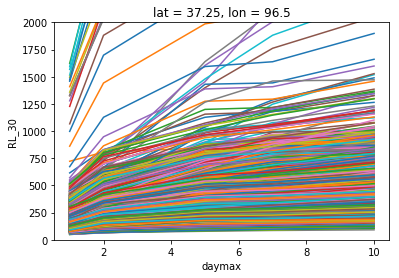

In [27]:
import matplotlib.pyplot as plt
total_lat = abc.lat.values
total_long = abc.lon.values
for i,lat1 in enumerate(total_lat):
    for j,lon1 in enumerate(total_long):
        daymax1 = abc['RL_100'].sel(lat = abc.lat[i],lon = abc.lon[j])
        if daymax1[0]>daymax1[1]:
            daymax1[:] = np.nan 
        elif daymax1[1]>daymax1[2]:
            daymax1[:] = np.nan
        elif daymax1[2]>daymax1[3]:
            daymax1[:] = np.nan
        elif daymax1[3]>daymax1[4]:
            daymax1[:] = np.nan                            
        else:
            daymax1.plot()
plt.ylim((0,3000))
plt.savefig('/home/akash/sd/divya/idfRL_100_allgrids_MICE_obs_divya.png')       

for i,lat1 in enumerate(total_lat):
    for j,lon1 in enumerate(total_long):
        daymax2 = abc['RL_30'].sel(lat = abc.lat[i],lon = abc.lon[j])
        if daymax2[0]>daymax2[1]:
            daymax2[:] = np.nan 
        elif daymax2[1]>daymax2[2]:
            daymax2[:] = np.nan
        elif daymax2[2]>daymax2[3]:
            daymax2[:] = np.nan
        elif daymax2[3]>daymax2[4]:
            daymax2[:] = np.nan                            
        else:
            daymax2.plot()
plt.ylim((0,2000))
plt.savefig('/home/akash/sd/divya/idfRL_30_allgrids_MICE_obs_divya.png') 
            

In [28]:
RL_100_1day_obsMICE = abc['RL_100'].sel(daymax = abc.daymax[0])
RL_100_1day_obsMICE

<xarray.DataArray 'RL_100' (lat: 117, lon: 115)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 95.75 96.0 96.25 96.5
    daymax   float64 1.0

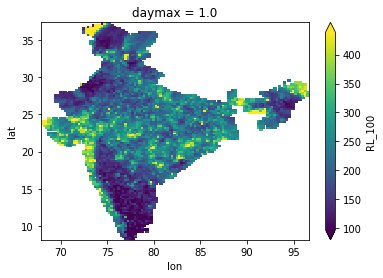

In [29]:
RL_100_1day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_1daymax.png')

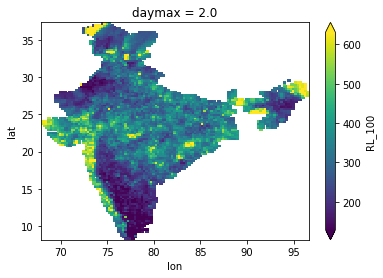

In [30]:
RL_100_2day_obsMICE = abc['RL_100'].sel(daymax = abc.daymax[1])
RL_100_2day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_2daymax.png')

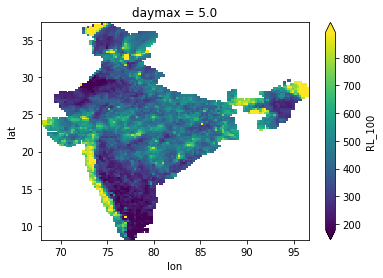

In [31]:
RL_100_5day_obsMICE = abc['RL_100'].sel(daymax = abc.daymax[2])
RL_100_5day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_5daymax.png')

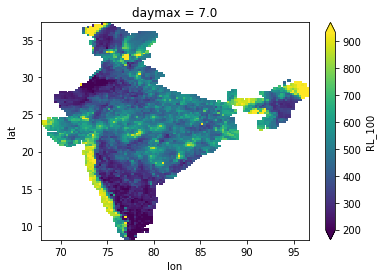

In [32]:
RL_100_7day_obsMICE = abc['RL_100'].sel(daymax = abc.daymax[3])
RL_100_7day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_7daymax.png')

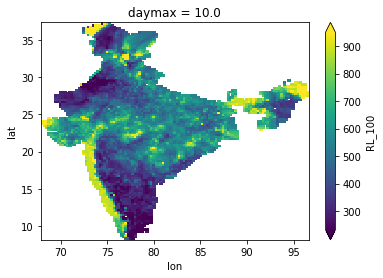

In [33]:
RL_100_10day_obsMICE = abc['RL_100'].sel(daymax = abc.daymax[4])
RL_100_10day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_10daymax.png')

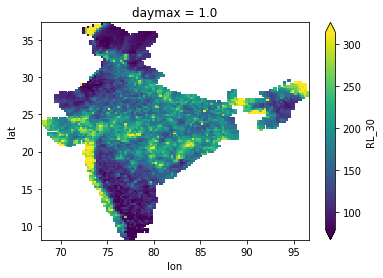

In [34]:
RL_30_1day_obsMICE = abc['RL_30'].sel(daymax = abc.daymax[0])
RL_30_1day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_1daymax.png')


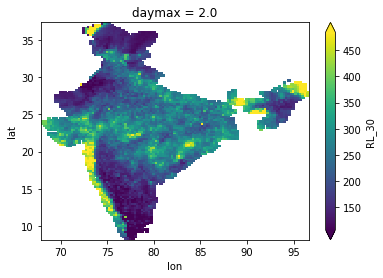

In [35]:
RL_30_2day_obsMICE = abc['RL_30'].sel(daymax = abc.daymax[1])
RL_30_2day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_2daymax.png')


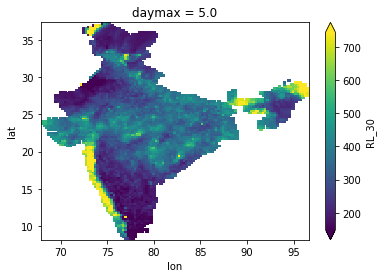

In [36]:

RL_30_5day_obsMICE = abc['RL_30'].sel(daymax = abc.daymax[2])
RL_30_5day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_5daymax.png')



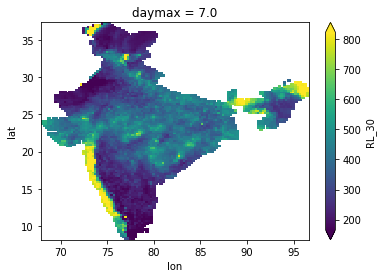

In [37]:
RL_30_7day_obsMICE = abc['RL_30'].sel(daymax = abc.daymax[3])
RL_30_7day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_7daymax.png')


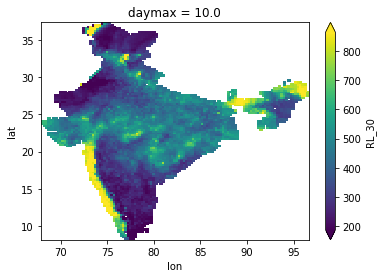

In [38]:

RL_30_10day_obsMICE = abc['RL_30'].sel(daymax = abc.daymax[4])
RL_30_10day_obsMICE.plot(robust = True)
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_10daymax.png')

In [39]:
from scipy.stats import iqr

In [40]:
df2 = pd.DataFrame({'lat':[],'lon':[],'iqr_RL_100':[],'iqr_RL_30':[]})
for i,lat1 in enumerate(total_lat):
        for j,lon1 in enumerate(total_long):
            daymax1 = abc['RL_100'].sel(lat = abc.lat[i],lon = abc.lon[j])
            xyz2 = iqr(daymax1)
            daymax2 = abc['RL_30'].sel(lat = abc.lat[i],lon = abc.lon[j])
            xyz3 = iqr(daymax2)
            df2 = df2.append({'lat':lat1,'lon':lon1,'iqr_RL_100':xyz2,'iqr_RL_30':xyz3},ignore_index=True)

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/akash/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation

In [126]:
df2

,iqr_RL_100,iqr_RL_30,lat,lon
0,NaN,NaN,8.25,68.00
1,NaN,NaN,8.25,68.25
2,NaN,NaN,8.25,68.50
3,NaN,NaN,8.25,68.75
4,NaN,NaN,8.25,69.00
5,NaN,NaN,8.25,69.25
6,NaN,NaN,8.25,69.50
7,NaN,NaN,8.25,69.75
8,NaN,NaN,8.25,70.00
9,NaN,NaN,8.25,70.25


In [41]:
df2 = df2.set_index(['lat','lon'])

In [42]:
df3 = df2.to_xarray()
df3.to_netcdf('/home/akash/sd/divya/iqr_obsMICE_RL10030_divya.nc')

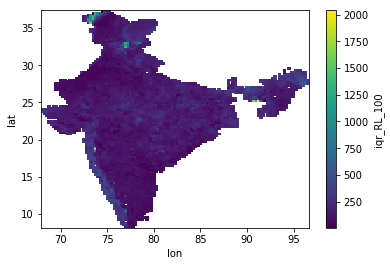

In [43]:
df3.iqr_RL_100.plot()
plt.savefig('/home/akash/sd/divya/RL_100_obsMICE_iqr_divya.png')

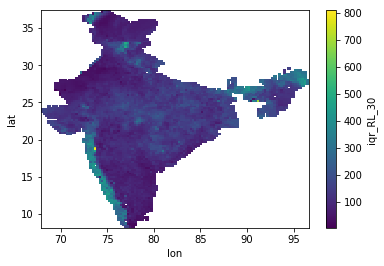

In [44]:
df3.iqr_RL_30.plot()
plt.savefig('/home/akash/sd/divya/RL_30_obsMICE_iqr_divya.png')

In [1]:
gcm_mice_corrected_obs_divya

NameError: name 'gcm_mice_corrected_obs_divya' is not defined